<a href="https://colab.research.google.com/github/sooking87/Data-Pattern/blob/master/DPR_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert를 이용한 가사 감정 분석

## [2024 DPR Proj] IT공학전공(주전공)-4학년-2116313-손수경

아래 기재한 숫자의 경우, 과제에서 요구하는 주의사항 번호임을 말씀드립니다.

- [깃허브 링크](https://github.com/sooking87/Data-Pattern/tree/master)


## 1. 프로젝트의 motivation

음악은 현대 사회에서 우리의 삶에서 더 이상 떼어 놓을 수 없는 중요한 요소가 되었습니다. 특히 유튜브 프리미엄이 등장하며 "집중 잘되는 플레이 리스트", "나는 아픈 건 딱 질색이니까 1시간" 등 음악 플레이리스트에 대한 영상이 증가하고 있습니다. <br>

그 중 가사는 많은 사람들에게 위로가 될 수 있고, 기분 전환의 계기를 제공하기도 합니다. 이에 따라, 가사의 감성을 자동으로 분석하고 긍정인지 부정인지를 판단하는 것을 목표로 합니다. 이를 위해 자연어 처리 기술 중 하나인 BERT를 활용하여 감정 분석 모델을 구축할 예정입니다. <br>

이 프로젝트를 통한 기대점
1. 음악 산업에 대한 인사이트 제공: 음악에 대한 장르/감정/분위기를 제공하여 팬이 아닌 사람들도 원한느 노래를 쉽게 접하고 들어볼 수 있습니다.
2. 자연어 처리 기술의 적용: 최근 Chat GPT로 인해 자연어 처리 기술의 정점을 찍고 있습니다. GPT와 같은 자연어 처리 기술 중 BERT를 사용함으로써 BERT에 대한 네트워크 분석, 활용을 통해 모델에 대해 공부할 수 있을 것을 예상합니다.

## 2. 프로그램의 데이터 패턴 종류

텍스트 데이터인 가사와 레이블은 긍정(1)/부정(0) 을 기준으로 학습시킬 예정입니다.

## 3. 데이터 수집 과정 및 augmentation 사용 기술

genius API의 search_song 메서드를 통해서 가사를 불러왔습니다. 사용하는 최종 데이터셋(lyrics_polarity_dataset.csv)은 artist, title, year, lyrics, com_sentiment, polarity, textblob_pol 칼럼으로 구성되어 있습니다.


- `lyrics`: 원본 가사(토큰화 전 가사)

- `polarity`: vader을 통해서 com_sentiment >= 0.05 라면 pos, 아니라면 neg 로 분리하였습니다.

- `textblob_pol`: textblob에서 제공하는 polarity 점수를 사용하였습니다.

### 3-1. genius API 사용해서 가사 불러오기

`Hot Stuff.csv` 파일 내의 `song`(노래 제목) , `performer`(가수) col과 geneius API를 통해서 해당 노래의 가사를 불러옵니다. <br/>

해당 데이터는 32만개의 노래 데이터가 있으나, 빌보드 차트에 오른 노래 데이터를 기반으로 하고 있기 때문에 중복되는 경우가 많습니다. 그럼에도 원본 데이터의 양이 많기 때문에 훈련하기에 충분하다는 생각이 들었습니다. <br/>

[번외] `Hot Stuff.csv` 데이터셋 csv 확인하기 <br/>

`Hot Stuff.csv` 파일 출처는 [파일 출처 링크](https://data.world/kcmillersean/billboard-hot-100-1958-2017) 에 있습니다.

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,592 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and dire

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# 깃허브에 올려둔 CSV 파일 다운로드
!wget -O hot_stuff.csv "https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/Hot_Stuff.csv"

# CSV 파일 로드
df = pd.read_csv('hot_stuff.csv', encoding='cp949')

# 데이터 확인 및 기초 통계
print(df.shape)
print(df.keys())
print(df.head())
print(df.info())
print(df.describe(include='all'))


--2024-05-31 04:26:24--  https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/Hot_Stuff.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45731337 (44M) [text/plain]
Saving to: ‘hot_stuff.csv’

hot_stuff.csv       100%[===================>]  43.61M  --.-KB/s    in 0.1s    

2024-05-31 04:26:28 (337 MB/s) - ‘hot_stuff.csv’ saved [45731337/45731337]

(327895, 10)
Index(['癤퓎rl', 'WeekID', 'Week Position', 'Song', 'Performer', 'SongID',
       'Instance', 'Previous Week Position', 'Peak Position',
       'Weeks on Chart'],
      dtype='object')
                                                癤퓎rl     WeekID  \
0  http://www.billboard.com/charts/hot-100/1965-0...  7/17/1965   
1  http://www.billboard.com/charts/hot-100/1965-0...  7

#### genius API를 이용해서 가사 불러오기

해당 가사를 불러오는데 시간이 너무 오래걸려 계속 코랩 연결이 끊어지는 문제점이 있었습니댜. 따라서 **전이 학습된 BERT** 를 사용하고자 하였으므로 중복없는 약 2만개의 데이터를 수집하기를 목표로 하였습니다. <br/>

또한 2만개의 데이터 역시 한 번에 불러오기에는 코랩 연결 시간이 짧아 6개로 나누어 약 3334개씩 가사 크롤링을 한 후 각각의 csv 파일로 저장 후 csv 파일을 DataFrame으로 읽어와 6개의 csv 파일을 합쳐주었습니다. 그렇기에 아래 크롤링 코드는 "이상적으로" Hot_Stuff.csv 파일이 크롤링 되었을 때를 가정하여 코드를 작성하였습니다. <br/>

데이터는 총 1주에 걸쳐 수집하였습니다. <br/>

아래 코드를 통해 얻은 데이터 <br/>
- `lyrics`: `song`(노래 제목) , `performer`(가수) col과 geneius API를 통해서 해당 노래의 가사를 불러옵니다.

```pyrhon
######### 크롤링 코드 -> 시간이 오래걸려 코드만 작성하여 두었습니다. #######################

import lyricsgenius
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import requests

def get_lyrics(title, artist):
  try:
      return genius.search_song(title, artist).lyrics
  except:
      return 'not found'

# Function to return sentiment score of each song
def get_lyric_sentiment(lyrics):
  sentiment = sid_obj.polarity_scores(lyrics)
  return sentiment


''' 원본 파일에서 가수, 제목을 통해서 가사 + 감정 점수 불러오기'''

# genius API 사용을 위한 토큰
genius = lyricsgenius.Genius(
    "lgHGVg-7RZ_QLMNZ-jeVn9lrCUfhyeR-FWe2QulGyeTU2DFYtfRVxwkGhLdCZIAa")
sid_obj = SentimentIntensityAnalyzer()

# 깃허브에 올려둔 CSV 파일 다운로드
!wget -O hot_stuff.csv "https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/Hot_Stuff.csv"

# CSV 파일 로드
df = pd.read_csv('hot_stuff.csv', encoding='cp949')

# 사용할 col 제외하고 drop 시키기
df = df.drop(
    ['癤퓎rl', 'WeekID',
    'Week Position', 'SongID', 'Instance', 'Previous Week Position', 'Peak Position', 'Weeks on Chart'], axis=1)

df.drop_duplicates(subset='Song', inplace=True)
df.reset_index(drop=True)

# 노래 가사 불러오기
lyrics = df.apply(
    lambda row: get_lyrics(row['Song'], row['Performer']), axis=1)

df['lyrics'] = lyrics
# not found 제거
df = df.drop(
    df[df['lyrics'] == 'not found'].index)

df.loc[-1] = ['21744', 'Rap', 'Sohn SooKyoung', '2024', '''Even in this moment, sitting in the lecture hallMy mind is complicated, endless questionsSookmyung Women's University, that professorWhy do you make my life so difficult.
ISTP, my inner passion and angerEven when I argue logically, all I get is silenceI want to challenge, raise my voiceProfessor, here's what I want to say to you
Professor, please understand my feelingsDon't ignore the cries of a studentThe walls of Sookmyung Women's University are too highI can't stand it anymore, please listen to my words
My time trapped in piles of assignmentsMy passion that doesn't reach the professorISTP, my independent soulShould I fight, in this unfairness?
On the campus of Sookmyung Women's UniversityI'm wandering to find my dreamIn conflicts with the professor
Professor, please understand my feelingsDon't ignore the cries of a studentThe walls of Sookmyung Women's University are too highI can't stand it anymore, please listen to my words
ISTP, finding my own pathTogether with the professorStudent's anger, heading towards tomorrowWe walk together, holding onto hope''', '0.6576']
df.to_csv("lyrics_sentiment_dataset.csv", index=False)
```
csv 파일로 저장 후 csv 파일을 DataFrame으로 읽어와 6개의 csv 파일을 합쳐주었다는 증거
![split_join 증거 이미지](https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/split_join_data.png)

In [ ]:
!pip install --upgrade lyricsgenius
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


### 3-2. SentimentIntensityAnalyzer 클래스를 사용하여 compound 감정 점수 가져오기

- vaderSentiment: `vaderSentiment`는 감성 분석을 위해 개발된 VADER (Valence Aware Dictionary and sEntiment Reasoner) 도구를 제공합니다. VADER는 특히 소셜 미디어 텍스트와 같은 짧은 텍스트에서 감정을 분석하는 데 유용합니다.
    - compound 점수: VADER의 "compound" 점수는 텍스트의 전반적인 감성을 나타내는 하나의 정규화된 값입니다. 이 점수는 -1(매우 부정적)에서 +1(매우 긍정적) 사이의 값을 가집니다. 텍스트의 각 단어의 감성 점수의 합을 계산 후 정규화하여 -1에서 +1 사이의 값으로 변환해주는 값입니다. 일반적을 0.05 이상의 경우는 긍정을, 0.05이하의 경우는 부정을 의미합니다. <br />

아래 코드를 통해 얻을 수 있는 데이터 <br />
    - `com_sentiment`: caderSentiment를 통해서 가져온 compound 점수 <br />
    - `polarity`: `com_sentiment`가 0.05이상의 경우는 긍정(1)로, 0.05이하의 경우는 부정(0)으로 표현하였습니다. <br />
    - `textblob_pol`: 문장의 감정 점수를 계산하여 각 문장의 긍정/부정성을 측정하여 칼럼을 추가하였습니다. <br/>

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pandas as pd


# Function to return sentiment score of each song
def get_lyric_sentiment(lyrics):
  sentiment = sid_obj.polarity_scores(lyrics)
  return sentiment

# textblob 패키지로 감정 분석하기
def sent_textblob_polarity(lyrics):
    polarity_score = TextBlob(lyrics).sentiment.subjectivity
    if float(polarity_score) > 0:
      return 1
    return 0

# vader
def sent_vader_compound(com):
  if float(com) >= 0.05:
    return 1
  return 0

# 깃허브에 올려둔 CSV 파일 다운로드
!wget -O lyrics_sentiment_dataset.csv "https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/lyrics_sentiment_dataset.csv"

# CSV 파일 로드
lyrics_sentiment_dataset = pd.read_csv('lyrics_sentiment_dataset.csv')
sid_obj = SentimentIntensityAnalyzer()

# Use get_lyric_sentiment to get sentiment score for all the song lyrics
# SentimentIntensityAnalyzer 클래스를 이용해서 가사의 감정 수치를 생성한다.
sentiment = lyrics_sentiment_dataset.apply(
    lambda row: get_lyric_sentiment(row['lyrics']), axis=1)
# df에 com_sentiment col 추가하기
for i in lyrics_sentiment_dataset.index.tolist():
    lyrics_sentiment_dataset.loc[i, 'com_sentiment'] = sentiment[i]['compound']

# com_sentiment를 통핸 긍정/부정 분리 및 textblob을 통한 또다른 긍정/부정 col 생성
for i in lyrics_sentiment_dataset.index.tolist():
  lyrics = lyrics_sentiment_dataset.loc[i, "lyrics"]
  lyrics_sentiment_dataset.loc[i, "polarity"] = sent_vader_compound(lyrics_sentiment_dataset.loc[i, "com_sentiment"])
  lyrics_sentiment_dataset.loc[i, "textblob_pol"] = sent_textblob_polarity(lyrics)

# 저는 실행마다 첫 번째 셸부터 돌리기에는 시간상 비효율이라는 생각이 들어 `lyrics_polarity_dataset.csv` 파일을 만들었습니다.
lyrics_sentiment_dataset.to_csv("lyrics_polarity_dataset.csv", index=False)

--2024-06-02 03:11:37--  https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/lyrics_sentiment_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28818999 (27M) [text/plain]
Saving to: ‘lyrics_sentiment_dataset.csv’

lyrics_sentiment_da 100%[===================>]  27.48M   146MB/s    in 0.2s    

2024-06-02 03:11:37 (146 MB/s) - ‘lyrics_sentiment_dataset.csv’ saved [28818999/28818999]



SentimentIntensityAnalyzer 클래스 샘플 사용 결과 보기 <br/>

아래 가사는 작사한 본인 데이터에 대해서 감정 분석을 진행한 결과입니다.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

def get_lyric_sentiment(lyrics):
  sentiment = sid_obj.polarity_scores(lyrics)
  return sentiment

lyrics = '''
Even in this moment, sitting in the lecture hall
My mind is complicated, endless questions
Sookmyung Women's University, that professor
Why do you make my life so difficult?
ISTP, my inner passion and anger

Even when I argue logically, all I get is silence
I want to challenge, raise my voice
Professor, here's what I want to say to you
Professor, please understand my feelings
Don't ignore the cries of a student
The walls of Sookmyung Women's University are too high
I can't stand it anymore, please listen to my words
My time trapped in piles of assignments

My passion that doesn't reach the professor
ISTP, my independent soul
Should I fight, in this unfairness?
On the campus of Sookmyung Women's University
I'm wandering to find my dream
In conflicts with the professor
Professor, please understand my feelings
Don't ignore the cries of a student

The walls of Sookmyung Women's University are too high
I can't stand it anymore, please listen to my words
ISTP, finding my own path
Together with the professor
Student's anger, heading towards tomorrow
We walk together, holding onto hope
'''

sent = get_lyric_sentiment(lyrics)
print(sent)

{'neg': 0.105, 'neu': 0.743, 'pos': 0.153, 'compound': 0.6576}


## 5. 데이터의 크기 및 개수, 용량, 데이터 크기의 타당성 (딥러닝 가능성)

1. 데이터의 크기 및 개수
    - 딥려닝을 위해서는 대규모의 데이터셋이 필요합니다. 일반적으로 새로운 모델을 구축하여 학습을 시키기 위해서는 수백만 개의 데이터가 필요합니다. 다만, pretrain 된 모델을 사용할 것이므로 최소 10000개의 데이터셋이 필요하다고 생각했습니다. 데이터 수집은 20000개를 하였습니다.
2. 데이터 크기의 타당성
    - Bert의 경우, 일반적으로 최대 길이를 128 또는 256 토큰으로 설정하여 너무 긴 텍스트는 잘라내거나, 너무 짧은 텍스트는 패딩을 추가할 수 있습니다. 본인의 경우는 최대 길이 128로 설정하여 모델을 컴파일하였습니다.
    - 또한 기존 데이터셋에서 겹치는 노래 가사를 제거하여 용량은 최소한으로 하고, 데이터셋, 하드웨어는 최대한 활용하는 식으로 구성하였습니다.

- 최종 데이터 구조 확인하기

--2024-06-02 03:26:25--  https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/lyrics_polarity_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28991695 (28M) [text/plain]
Saving to: ‘lyrics_polarity_dataset.csv’

lyrics_polarity_dat 100%[===================>]  27.65M  --.-KB/s    in 0.1s    

2024-06-02 03:26:25 (228 MB/s) - ‘lyrics_polarity_dataset.csv’ saved [28991695/28991695]

(21745, 8)
Index(['Unnamed: 0', 'artist', 'title', 'year', 'lyrics', 'com_sentiment',
       'polarity', 'textblob_pol'],
      dtype='object')


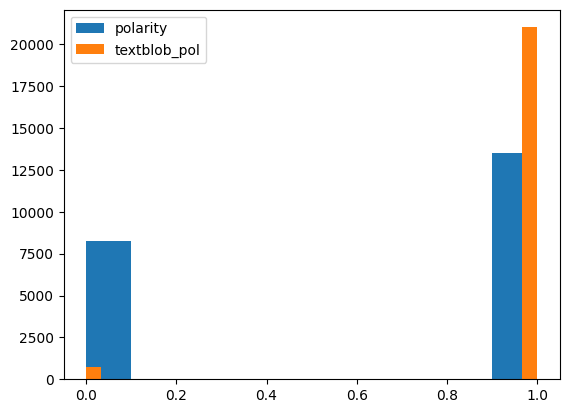

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 깃허브에 올려둔 CSV 파일 다운로드
!wget -O lyrics_polarity_dataset.csv "https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/lyrics_polarity_dataset.csv"

# CSV 파일 로드
df = pd.read_csv('lyrics_polarity_dataset.csv')

# 데이터 확인 및 기초 통계
print(df.shape)
print(df.keys())

polarity = df['polarity']
textblob_pol = df['textblob_pol']

plt.hist(polarity, label='polarity')
plt.hist(textblob_pol, bins=30, label='textblob_pol')
plt.legend()
plt.show()

- 결론적으로 `lyrics_polarity_dataset.csv` 데이터셋 내에서 `lyrics`와 `polarity`를 사용하며 데이터 개수는 총 21745개 입니다.

In [5]:
import pandas as pd

# 깃허브에 올려둔 CSV 파일 다운로드
!wget -O lyrics_polarity_dataset.csv "https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/lyrics_polarity_dataset.csv"

# CSV 파일 로드
lyrics_polarity_dataset = pd.read_csv('lyrics_polarity_dataset.csv')
print(lyrics_polarity_dataset.tail())
###### 21744 행을 보면 본인 데이터를 추가한 것을 볼 수 있습니다.

--2024-06-02 03:26:00--  https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/lyrics_polarity_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28991695 (28M) [text/plain]
Saving to: ‘lyrics_polarity_dataset.csv’

lyrics_polarity_dat 100%[===================>]  27.65M   106MB/s    in 0.3s    

2024-06-02 03:26:02 (106 MB/s) - ‘lyrics_polarity_dataset.csv’ saved [28991695/28991695]

       Unnamed: 0      artist                          title  year  \
21740       21740      m.o.p.  ante up (robbin hoodz theory)  2019   
21741       21741        nine                  whutcha want?  2019   
21742       21742  will smith                         switch  2019   
21743       21743       jeezy                         r.i.p.  2

## 4. 전이학습이나, 타인의 데이터를 추가한 경우, 그 데이터에 대한 설명

- 전이 학습 모델 중 Bert를 사용할 예정입니다. 자세한 사항에 대해서는 아래 6번에서 설명드리겠습니다.
- 타인의 데이터를 추가한 것은 없습니다. 모두 크롤링 및 생성으로 진행하였습니다.

## 6. 본인의 딥러닝 프로그래밍에 대한 자세한 설명 (딥네트웍 구조 등)

### BERT Explained: State of the art language model for NLP

<https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270> <br>

#### How BERT works

BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. In its vanilla form, Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task. <br>
<br>

As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word). <br>
<br>

When training language models, there is a challenge of defining a prediction goal. 빈칸에 들어가는 단어를 예측하는데 어려움이 있다. 왜? directional approach 자체의 한계점이다. 이를 극복하기 위해서 BERT는 2가지 전략을 사용한다.

1. Masked LM (MLM)

   Before feeding word sequences into BERT, 15% of the words in each sequence are replaced with a [MASK] token. The model then attempts to predict the original value of the masked words, based on the context provided by the other, non-masked, words in the sequence.

   ![download1](https://user-images.githubusercontent.com/96654391/188531248-8bf6007f-0289-434d-a94f-79556ef41e40.png)

   1. Adding a classification layer on top of the encoder output.
   2. Multiplying the output vectors by the embedding matrix, transforming them into the vocabulary dimension.
   3. Calculating the probability of each word in the vocabulary with softmax. <br>

2. Next Sentence Prediction (NSP)

   During training, 50% of the inputs are a pair in which the second sentence is the subsequent sentence in the original document, while in the other 50% a random sentence from the corpus is chosen as the second sentence. The assumption is that the random sentence will be disconnected from the first sentence. <br>
   이런 문제가 있어서 BERT에서는 문장 시작 부분에 [CLS] 끝나는 부분에 [SEP]을 붙혀서 토큰화, 임베딩을 한다. <br>

   ![download2](https://user-images.githubusercontent.com/96654391/188532302-3ae6c9dc-f3a2-42b8-a662-32450e7e3ce5.png) <br>

   To predict if the second sentence is indeed connected to the first, the following steps are performed: <br>

   1. The entire input sequence goes through the Transformer model.
   2. The output of the [CLS] token is transformed into a 2×1 shaped vector, using a simple classification layer (learned matrices of weights and biases).
   3. Calculating the probability of IsNextSequence with softmax.

#### How to use BERT (Fine-tuning)

In the fine-tuning training, most hyper-parameters stay the same as in BERT training, and the paper gives specific guidance (Section 3.5) on the hyper-parameters that require tuning. The BERT team has used this technique to achieve state-of-the-art results on a wide variety of challenging natural language tasks, detailed in Section 4 of the paper. <br>

BERT’s bidirectional approach (MLM) converges slower than left-to-right approaches (because only 15% of words are predicted in each batch) but bidirectional training still outperforms left-to-right training after a small number of pre-training steps.



#### How BERT works

The transformer is the part of the model that gives BERT its increased capacity for understanding context and ambiguity in language. The transformer does this by processing any given word in relation to all other words in a sentence, rather than processing them one at a time. the Transformer allows the BERT model to understand the full context of the word, and therefore better understand searcher intent. <br>

BERT uses a method of masked language modeling to keep the word in focus from "seeing itself" -- that is, having a fixed meaning independent of its context.



#### What is BERT Tokenizer?

The tokenizers should also match the core model that we would like to use as the pre-trained, e.g. cased and uncased version. <br>

<https://huggingface.co/docs/transformers/model_doc/bert#berttokenizer> : BERT 하이퍼 파라미터 정리 <br>

#### from_pretrained()

Transformers를 통해 저장된 모델은 기본적으로 pretrained model, tokenizer, vocab, config 파일 등을 포함하고 있으며, from_pretrained() 메소드를 통해 로드할 수 있다. <br>

***결론적으로 tokenizer를 이용해서 태그를 추가해준 후 모델 훈련을 시킬 수 있다.***

In [ ]:
!pip install keras
!pip install nltk
!pip install tensorflow

### 6-1. Bert에 넣기 위한 input 데이터 전처리(태그 추가)

저는 실행마다 첫 번째 셸부터 돌리기에는 시간상 비효율이라는 생각이 들어 `lyrics_polarity_dataset.csv` 파일을 만들었습니다. <br>

In [1]:
from transformers import BertTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# 깃허브에 올려둔 CSV 파일 다운로드
!wget -O lyrics_polarity_dataset.csv "https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/lyrics_polarity_dataset.csv"

# CSV 파일 로드
df = pd.read_csv('lyrics_polarity_dataset.csv')
print(df.shape)
# train-set, test-set 분리
X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['polarity'], test_size=0.25, random_state=32)
# X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['textblob_pol'], test_size=0.25, random_state=32)
print(X_train.shape)

# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

def tokenize_data(texts, labels, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
            truncation=True
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.convert_to_tensor(labels)

    return input_ids, attention_masks, labels

# Train 데이터 토큰화
train_input_ids, train_attention_masks, train_labels = tokenize_data(X_train, y_train, tokenizer)

# Test 데이터 토큰화
test_input_ids, test_attention_masks, test_labels = tokenize_data(X_test, y_test, tokenizer)

# TensorFlow 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_input_ids, 'attention_mask': train_attention_masks}, train_labels)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': test_input_ids, 'attention_mask': test_attention_masks}, test_labels)).batch(16)


--2024-06-02 03:34:18--  https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Data-Preprocessing/lyrics_polarity_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28991695 (28M) [text/plain]
Saving to: ‘lyrics_polarity_dataset.csv’

lyrics_polarity_dat 100%[===================>]  27.65M  86.2MB/s    in 0.3s    

2024-06-02 03:34:19 (86.2 MB/s) - ‘lyrics_polarity_dataset.csv’ saved [28991695/28991695]

(21745, 8)
(16308,)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
print(train_dataset)

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


### 6-2. Model Compile and Fit

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# 모델 초기화
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

# 옵티마이저, 손실 함수, 메트릭 정의
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# 모델 학습
history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)

# 모델 가중치 저장
model.save_weights("final_model_weights.h5")


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1020/1020 [==============================] - 610s 510ms/step - loss: 0.5002 - accuracy: 0.7474 - val_loss: 0.4744 - val_accuracy: 0.7594
Epoch 2/3
1020/1020 [==============================] - 506s 496ms/step - loss: 0.3728 - accuracy: 0.8365 - val_loss: 0.5744 - val_accuracy: 0.7421
Epoch 3/3
1020/1020 [==============================] - 539s 528ms/step - loss: 0.2754 - accuracy: 0.8860 - val_loss: 0.5779 - val_accuracy: 0.7747


### 6-3. Model Load

In [ ]:
!pip install keras
!pip install nltk
!pip install tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# 깃허브에 가중치 파일은 용량이 커 업로드가 되지 않습니다.

Mounted at /content/drive


In [3]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

# 옵티마이저, 손실 함수, 메트릭 정의
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# 가중치 파일 경로
weights_path = '/content/drive/MyDrive/Colab Notebooks/DPR Proj/final_model_weights.h5'
model.load_weights(weights_path)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from transformers import BertTokenizer
# 새로운 텍스트 예측
texts = [
    '''Hope it's all the I have
    The calm in the storm
    Is right where I am
    Inside of hope
    It's all that I know
    It's what I'm moved toward
    It's what I live for

    Wave goodbye to a time
    That you once believed was everything

    I'm ready to live
    I'm ready to dream
    I'm ready for fear, and love and everything between

    Don't tell me I'm right
    Don't tell me I'm wrong
    Just tell me I'm strong enough for one more song
    And this could be the one to say it right
    Bringing warmth into the night
    I'm going to broke, but I've got hope'''
]
# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
encoded_texts = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='tf')

predictions = model.predict(encoded_texts)
# 로짓을 소프트맥스 함수로 확률로 변환
probs = tf.nn.softmax(predictions.logits, axis=-1)
predicted_labels = tf.argmax(probs, axis=1)

print(f"Predicted label: {predicted_labels[0].numpy()} with probability: {probs[0][predicted_labels[0]].numpy() * 100:.2f}%")

1/1 [==============================] - 27s 27s/step
Predicted label: 1 with probability: 99.36%


## 7. 결과에 대한 충분한 분석과 설명(도표나, 결과 화면을 캡춰해서 제시)

- 결과 코드 셸이 지워질 수 있어 이미지로도 제출합니다.

![res](https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Sample-Result/pos-1.png)
![res](https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Sample-Result/pos-2.png)
![res](https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Sample-Result/neg-1.png)
![res](https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Sample-Result/neg-2.png)
![res](https://raw.githubusercontent.com/sooking87/Data-Pattern/master/Sample-Result/com-2.png)

In [ ]:
#### you are my sunshine - Chirstina Perri
from transformers import BertTokenizer
# 새로운 텍스트 예측
texts = [
    '''You are my sunshine
    My only sunshine
    You make me happy
    When skies are gray
    You'll never know, dear
    How much I love you
    Please don't take
    My sunshine away
    The other night, dear
    As I lay sleeping
    I dreamed I held you
    In my arms
    When I awoke, dear
    I was mistaken
    So I hung my head and cried
    You are my sunshine
    My only sunshine
    You make me happy
    When skies are gray
    You'll never know, dear
    How much I love you
    Please don't take
    My sunshine away'''
]
# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
encoded_texts = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='tf')

predictions = model.predict(encoded_texts)
# 로짓을 소프트맥스 함수로 확률로 변환
probs = tf.nn.softmax(predictions.logits, axis=-1)
predicted_labels = tf.argmax(probs, axis=1)

print(f"Predicted label: {predicted_labels[0].numpy()} with probability: {probs[0][predicted_labels[0]].numpy() * 100:.2f}%")

1/1 [==============================] - 0s 55ms/step
Predicted label: 1 with probability: 99.40%


In [ ]:
#### It's a Beautiful Day - Jermaine Edwards, Rushawn, and The Kiffness
from transformers import BertTokenizer
# 새로운 텍스트 예측
texts = [
    '''You are my sunshine
    My only sunshine
    You make me happy
    When skies are gray
    You'll never know, dear
    How much I love you
    Please don't take
    My sunshine away
    The other night, dear
    As I lay sleeping
    I dreamed I held you
    In my arms
    When I awoke, dear
    I was mistaken
    So I hung my head and cried
    You are my sunshine
    My only sunshine
    You make me happy
    When skies are gray
    You'll never know, dear
    How much I love you
    Please don't take
    My sunshine away'''
]
# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
encoded_texts = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='tf')

predictions = model.predict(encoded_texts)
# 로짓을 소프트맥스 함수로 확률로 변환
probs = tf.nn.softmax(predictions.logits, axis=-1)
predicted_labels = tf.argmax(probs, axis=1)

print(f"Predicted label: {predicted_labels[0].numpy()} with probability: {probs[0][predicted_labels[0]].numpy() * 100:.2f}%")

1/1 [==============================] - 0s 75ms/step
Predicted label: 1 with probability: 99.40%


In [ ]:
#### 부정적인 노래는 일반적으로 없어 GPT한테 부정적인 가사를 생성해달라고 한 후 테스트를 진행하였습니다.
from transformers import BertTokenizer
# 새로운 텍스트 예측
texts = [
    '''
    I walk these empty streets, alone with my despair,
    The shadows whisper secrets, of a life beyond repair.
    Every step I take, the ground just falls away,
    And in the cold, dark night, I curse another day.
    Broken dreams and shattered lies,
    Underneath these blackened skies.
    Hope has fled and left me bare,
    In this world, it's just not fair.
    The silence screams so loud, it drowns my every thought,
    In this prison of my mind, happiness can't be bought.
    Lost within my fears, there's no light left to see,
    The weight of all my pain, is slowly crushing me.
    Broken dreams and shattered lies,
    Underneath these blackened skies.
    Hope has fled and left me bare,
    In this world, it's just not fair.
    I've tried to find a way, to rise above it all,
    But every time I stand, I only seem to fall.
    The darkness pulls me down, with every breath I take,
    And in this endless night, my heart begins to break.
    Broken dreams and shattered lies,
    Underneath these blackened skies.
    Hope has fled and left me bare,
    In this world, it's just not fair.
    '''
]
# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
encoded_texts = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='tf')

predictions = model.predict(encoded_texts)
# 로짓을 소프트맥스 함수로 확률로 변환
probs = tf.nn.softmax(predictions.logits, axis=-1)
predicted_labels = tf.argmax(probs, axis=1)

print(f"Predicted label: {predicted_labels[0].numpy()} with probability: {probs[0][predicted_labels[0]].numpy() * 100:.2f}%")

1/1 [==============================] - 0s 58ms/step
Predicted label: 0 with probability: 97.11%


In [ ]:
#### 부정적인 노래는 일반적으로 없어 GPT한테 부정적인 가사를 생성해달라고 한 후 테스트를 진행하였습니다.
from transformers import BertTokenizer
# 새로운 텍스트 예측
texts = [
    '''
    Falling deeper into the abyss, where light cannot be found,
    Surrounded by the emptiness, I can’t hear a single sound.
    The walls are closing in on me, suffocating my last breath,
    In this cold and lonely darkness, I can only think of death.
    This heart of mine is breaking,
    From the endless pain I'm taking.
    All the love has turned to hate,
    And it feels like it’s too late.
    Every promise that was made, is now a bitter lie,
    The memories of better days, just make me want to cry.
    Trust has been betrayed, and dreams have turned to dust,
    In this world of hopelessness, there's no one left to trust.
    This heart of mine is breaking,
    From the endless pain I'm taking.
    All the love has turned to hate,
    And it feels like it’s too late.
    I've screamed into the void, but no one hears my call,
    The echoes of my suffering, bounce off these empty walls.
    In the silence of my solitude, the shadows start to creep,
    And in the grip of misery, I find it hard to sleep.
    This heart of mine is breaking,
    From the endless pain I'm taking.
    All the love has turned to hate,
    And it feels like it’s too late.
    '''
]
# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
encoded_texts = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='tf')

predictions = model.predict(encoded_texts)
# 로짓을 소프트맥스 함수로 확률로 변환
probs = tf.nn.softmax(predictions.logits, axis=-1)
predicted_labels = tf.argmax(probs, axis=1)

print(f"Predicted label: {predicted_labels[0].numpy()} with probability: {probs[0][predicted_labels[0]].numpy() * 100:.2f}%")

1/1 [==============================] - 0s 56ms/step
Predicted label: 0 with probability: 96.45%


In [ ]:
#### 중립적인 노래는 일반적으로 없어 GPT한테 중립적인 가사를 생성해달라고 한 후 테스트를 진행하였습니다.
from transformers import BertTokenizer
# 새로운 텍스트 예측
texts = [
    '''
    The rain begins to fall, tapping on my windowpane,
    A soothing rhythm fills the air, a natural refrain.
    No rush, no hurry in this time, just a gentle flow,
    Watching as the droplets fall, in the world below.
    '''
]
# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
encoded_texts = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='tf')

predictions = model.predict(encoded_texts)
# 로짓을 소프트맥스 함수로 확률로 변환
probs = tf.nn.softmax(predictions.logits, axis=-1)
predicted_labels = tf.argmax(probs, axis=1)

print(f"Predicted label: {predicted_labels[0].numpy()} with probability: {probs[0][predicted_labels[0]].numpy() * 100:.2f}%")

1/1 [==============================] - 0s 83ms/step
Predicted label: 1 with probability: 65.97%


## 8. 프로젝트를 위해 활용한 자료나, 동영상 링크

- Fine-tune BERT Model for Sentiment Analysis in Google Colab: <https://www.analyticsvidhya.com/blog/2021/12/fine-tune-bert-model-for-sentiment-analysis-in-google-colab/#:~:text=Introduction%20to%20BERT%20Model%20for,negative%2C%20or%20neutral%20about%20it.>

- BERT 설명 pdf: <https://arxiv.org/pdf/1706.03762.pdf>

- BERT language model: <https://www.techtarget.com/searchenterpriseai/definition/BERT-language-model#:~:text=BERT%2C%20which%20stands%20for%20Bidirectional,calculated%20based%20upon%20their%20connection>

- Transformer와 Tensorflow를 가지고 fine-tunning 해보기: <https://velog.io/@jaehyeong/Fine-tuning-Bert-using-Transformers-and-TensorFlow>


## 9. 본 프로젝트를 통해 느낀점

데이터 수집부터 모델 훈련 및 결과 도출까지의 과정은 이번 프로젝트에서 처음 경험하는 일이었습니다. 프로젝트를 진행하면서, 모델을 불러와 사용하는 시간보다 데이터를 수집하고 전처리하는 과정이 훨씬 더 오래 걸린다는 것을 깨달았습니다. <br>

특히, 데이터 수집 과정은 예상했던 일정보다 훨씬 더 많은 시간이 소요되었습니다. 처음에는 가사와 감정 라벨이 포함된 데이터를 찾으려 했으나, 해당 데이터셋은 양이 적거나 가사 원본이 포함되지 않는 경우가 많았습니다. 결국, 가수와 노래 제목을 기준으로 크롤링을 진행하기로 결정했습니다. <br>

그러나 크롤링 과정도 쉽지 않았습니다. 가사를 크롤링하는 데 생각보다 많은 시간이 소요되었고, 하루 종일 노트북을 켜놓지 않으면 약 2만 개의 데이터를 한 번에 수집하기 어려웠습니다. 그래서 데이터를 6등분하여 약 3,000개씩 나누어 수집하고, 백업용으로 CSV 파일에 저장했습니다. <br>

어렵게 데이터를 수집한 후, 전처리하여 BERT 모델에 입력하려고 했습니다. 일반적으로 자연어 처리에서는 불용어(stopword)를 제거하고 표제어를 추출하는 과정이 필수적입니다. 이러한 전처리 과정을 거쳐 데이터를 준비하려 했으나, BERT에 대해 더 깊이 공부하면서 토크나이저(tokenizer)를 통해 데이터를 임베딩하고 입력할 수 있다는 사실을 알게 되었습니다. <br>

이에 따라 전처리 단계를 최소화하고 원본 데이터를 토크나이저를 통해 BERT에 적합한 입력 형태로 변환하였습니다. 이로 인해 모델의 정확도를 크게 향상시킬 수 있었습니다. BERT 모델에 대해 학습한 덕분에, 생각보다 빠르게 모델의 성능을 개선할 수 있었고, 그 결과에 대해 매우 만족스러웠습니다. <br>

이 프로젝트를 통해 데이터 수집 및 전처리의 중요성을 실감할 수 있었고, BERT 모델의 강력한 자연어 처리 능력을 직접 경험할 수 있었습니다. 앞으로 이러한 경험을 바탕으로 더욱 효율적이고 정확한 자연어 처리 프로젝트를 수행할 수 있을 것이라 기대합니다.


## 10. 프로젝트 수행 과정에 대한 간략한 일정 고찰

1. 데이터 수집(1.5주)
    - 처음 3일간 원하는 데이터가 있는지를 찾아보았습니다.
    - 원하는 데이터가 없어 크롤링을 시도하였습니다.
        - 도전 과제: 크롤링 속도가 느려 데이터 수집에 많은 시간이 소요되었습니다. 이를 해결하기 위해 데이터를 나누어 병렬로 수집하고 백업 파일(csv)을 생성하였습니다.

2. 데이터 전처리 (0.5주)

    - 데이터 정제: 수집한 데이터에서 불필요한 문자나 특수 문자를 제거합니다.
    - 토크나이징: BERT 모델에 맞게 데이터를 토크나이저를 통해 토크나이징합니다.
        - 도전 과제: 불용어 제거와 표제어 추출의 불필요성을 인지 후, 토크나이저를 사용하여 보다 효율적인 전처리 방법을 적용하였습니다.

3. 모델 훈련 및 모델 평가/튜닝(0.5주)
    - 모델 평가: 초기에 데이터 수집 시 polarity, textblob_pol 칼럼을 생성하였는데, 각각의 칼럼을 레이블로 사용하여 높은 성능을 가진 가중치를 사용하고자 하였습니다.
    - 아쉬운 점: 첫 번째 컴파일 이후 급격히 훈련 속도가 느려져.. polarity 칼럼 레이블만 훈련이 완료된 상태입니다. 하드웨어 상의 이유로 하고자 했던 훈련을 여러 번 시켜보지 못하여 아쉬움이 크게 남습니다. 또한 수업 시간에 배운 교차 검증을 사용하여 성능 비교를 해보고 싶었으나, 훈련시간이 너무 오래걸리고, 제한된 하드웨어의 이유로 실험을 해보지 못한 점이 아쉬웠습니다.